<h1> Spatial Clustering Insights from the 2023 City of Vancouver Property Tax Report </h1>

In [1]:
## Load Relevant Libraries 

# Tidyverse library used for wrangling and tidying data
library(tidyverse)

# Tidymodels library used for kmeans clustering
library(tidymodels)

# Broom used for tidy visualization of clustering
library(broom)

# ggpairs used to sort out which variables correlate strongly with each other
library(GGally)

seed <- 9876

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<h1> 1. Data Specification </h1>
This project uses data from the City of Vancouver Open Data Portal 

In [2]:
#setting seed
set.seed(9876)
seed <- 9876

## 2023 CoV Property Tax Report Dataset imported by url (HTTP GET)
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   ZONING_CLASSIFICATION,
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   NEIGHBOURHOOD_CODE,
                   TAX_LEVY)

## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)

# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_parcel_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",") |>
# Convert (lat,long) into numeric data
            mutate(lat = as.double(lat)) |>
            mutate(long = as.double(long))

Rows: 220840 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100164 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
## Data Tidying
# Filter for housing properties only by zone
property_housing_only <- ptax_parcel_merged |>
    filter(ZONING_CLASSIFICATION == c("Comprehensive Development",
                                      # NOTE: Comprehensive Developments are mixed-use, and could look like an 
                                      # apartment building with shops below, or a shopping mall with a few apartments
                                      # above. This report acknowledges the limitations of this in further sections.
                                      "Single Detached House",
                                      "Multiple Dwelling"))

print(paste("Entry Count before NA and 0 removal: ", nrow(property_housing_only))) 
property_housing_only <- property_housing_only |>
                            filter(CURRENT_LAND_VALUE > 0,
                                   CURRENT_IMPROVEMENT_VALUE > 0,
                                   YEAR_BUILT > 0,
                                   BIG_IMPROVEMENT_YEAR > 0) |>
                            drop_na()
print(paste("Entry Count after NA and 0 removal: ", nrow(property_housing_only)))

# Summary table counting each housing type
property_summ_table <- property_housing_only |>
    group_by(ZONING_CLASSIFICATION) |>
    summarize(COUNT = n())
property_summ_table 

Warning message in ZONING_CLASSIFICATION == c("Comprehensive Development", "Single Detached House", :
“longer object length is not a multiple of shorter object length”


[1] "Entry Count before NA and 0 removal:  60865"
[1] "Entry Count after NA and 0 removal:  58954"


ZONING_CLASSIFICATION,COUNT
<chr>,<int>
Comprehensive Development,26485
Multiple Dwelling,10378
Single Detached House,22091


<h2> Aggregate Measurements </h2>

`summarise()` has grouped output by 'lat'. You can override using the `.groups`
argument.


[1] "Same-address Property Value Entries: 27152  /  58954  ( 46.06 % ) total"


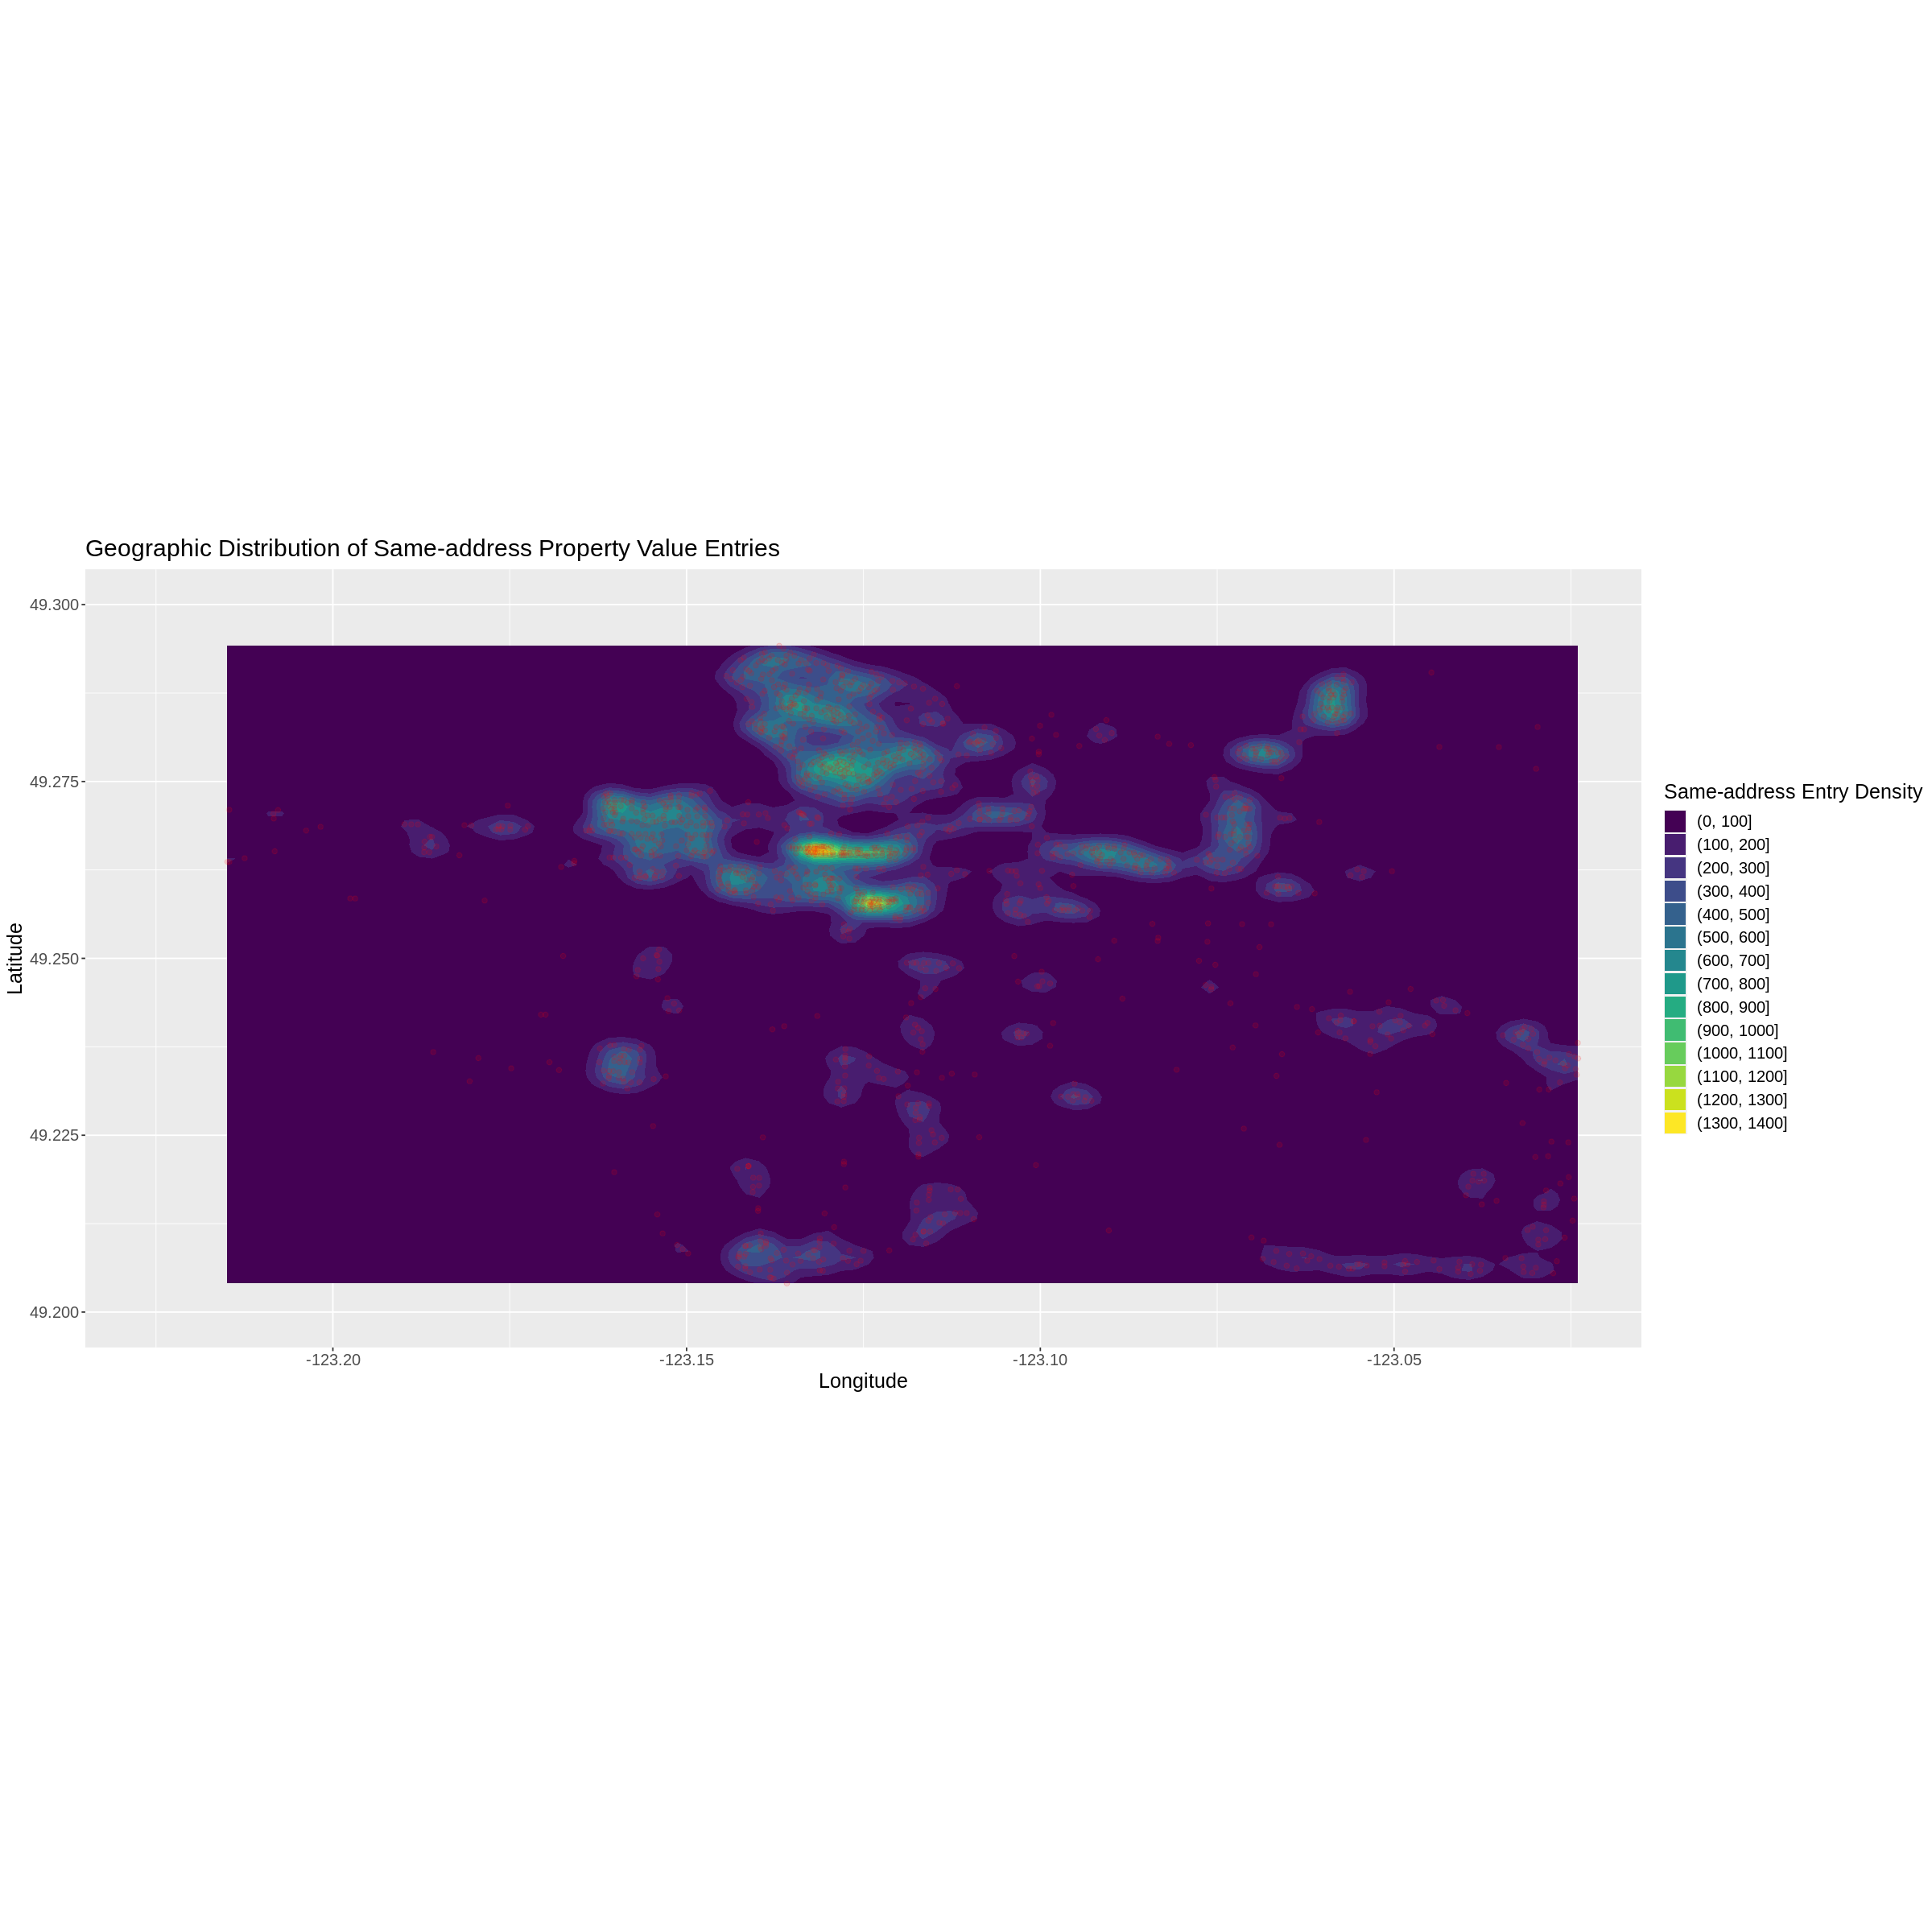

In [4]:
## Address Aggregation
# Computation of aggregate statistics:
housing_aggregated <- property_housing_only |>
                        group_by(lat, long) |>
                        arrange(long) |>
                        summarize(AGGREGATE_CURRENT_LAND_VALUE = sum(CURRENT_LAND_VALUE),
                                  AGGREGATE_IMPROVEMENT_VALUE = sum(CURRENT_IMPROVEMENT_VALUE),
                                  MEAN_YEAR_BUILT = mean(YEAR_BUILT),
                                  MEAN_BIG_IMPROVEMENT_YEAR = mean(BIG_IMPROVEMENT_YEAR),
                                  MEAN_TAX_LEVY = mean(TAX_LEVY),
                                  SAME_ADDRESS_ENTRIES = n()) |>
                        as_tibble()

print(paste("Same-address Property Value Entries:", nrow(housing_aggregated), " / ", nrow(property_housing_only),
            " (", signif(nrow(housing_aggregated) / nrow(property_housing_only) * 100, 4), "% ) total"))

# Plot Geographic distribution of Same-Address Property Tax Report Entries
options(repr.plot.width = 20, repr.plot.height =20)
property_plot <- housing_aggregated |>
                filter(SAME_ADDRESS_ENTRIES > 1) |>
                ggplot(aes(x=long,y=lat, z= SAME_ADDRESS_ENTRIES)) +
                geom_density_2d_filled(adjust = 1/4) +
                geom_point(alpha = 0.125, color = "red") +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     fill = "Same-address Entry Density", 
                     title = "Geographic Distribution of Same-address Property Value Entries") +
                theme(text = element_text(size = 15))
property_plot

<h1> 2. Calculating Spatial Centroids </h1>

This project will use the spatial centroids of properties within each neighbourhood coded in the Property Tax Report  as an external validation. The first set of centroids consist of those that take into consideration all types of properties within a neighbourhood, and the second set of centroids consist of those that only take the locations of strata housing into consideration.  

<h2> Neighbourhood Centroids using All Properties </h2>

In [5]:
## Strata Housing Centroids
# Assign Neighbourhood Names to Neighbourhood Codes in the Property Tax Dataset
ptax_centroids <- property_housing_only |>
        group_by(NEIGHBOURHOOD_CODE) |>
        mutate(lat = as.numeric(lat)) |>
        mutate(long = as.numeric(long)) |>
        summarize(centroid_lat = mean(lat),
                  centroid_long = mean(long))

neighbourhoods <- tibble(NEIGHBOURHOOD_CODE = c("001", "002", "003", "004", "005", "006", "007", "008", "009", "010", "011", "012", "013", "014", "015",
                                                "016", "017", "018", "019", "020", "021", "022", "023", "024", "025", "026", "027", "028", "029", "030"),
                         NEIGHBOURHOOD_NAME = c("Point Grey", "Kitsilano", "Dunbar", "Arbutus", 
                                                "Kerrisdale",  "Southlands", "Fairview", "Shaughnessy", "South Granville", 
                                                "Cambie", "Oakridge/South Cambie", "Marpole", "Mt. Pleasant East", "Hastings", 
                                                "Fraser", "Main", "South Vancouver", "South Marine", "Knight/Victoria", "Hastings Sunrise", 
                                                "Renfrew", "Renfrew Heights", "Collingwood", "Killarney", "Fraser View/Champlain Heights", 
                                                "Gastown/Chinatown", "West End", "Coal Harbour", "Yaletown", "False Creek"))
ptax_centroids <- inner_join(ptax_centroids, neighbourhoods, by = "NEIGHBOURHOOD_CODE")

Warning message:
“Duplicated aesthetics after name standardisation: colour”


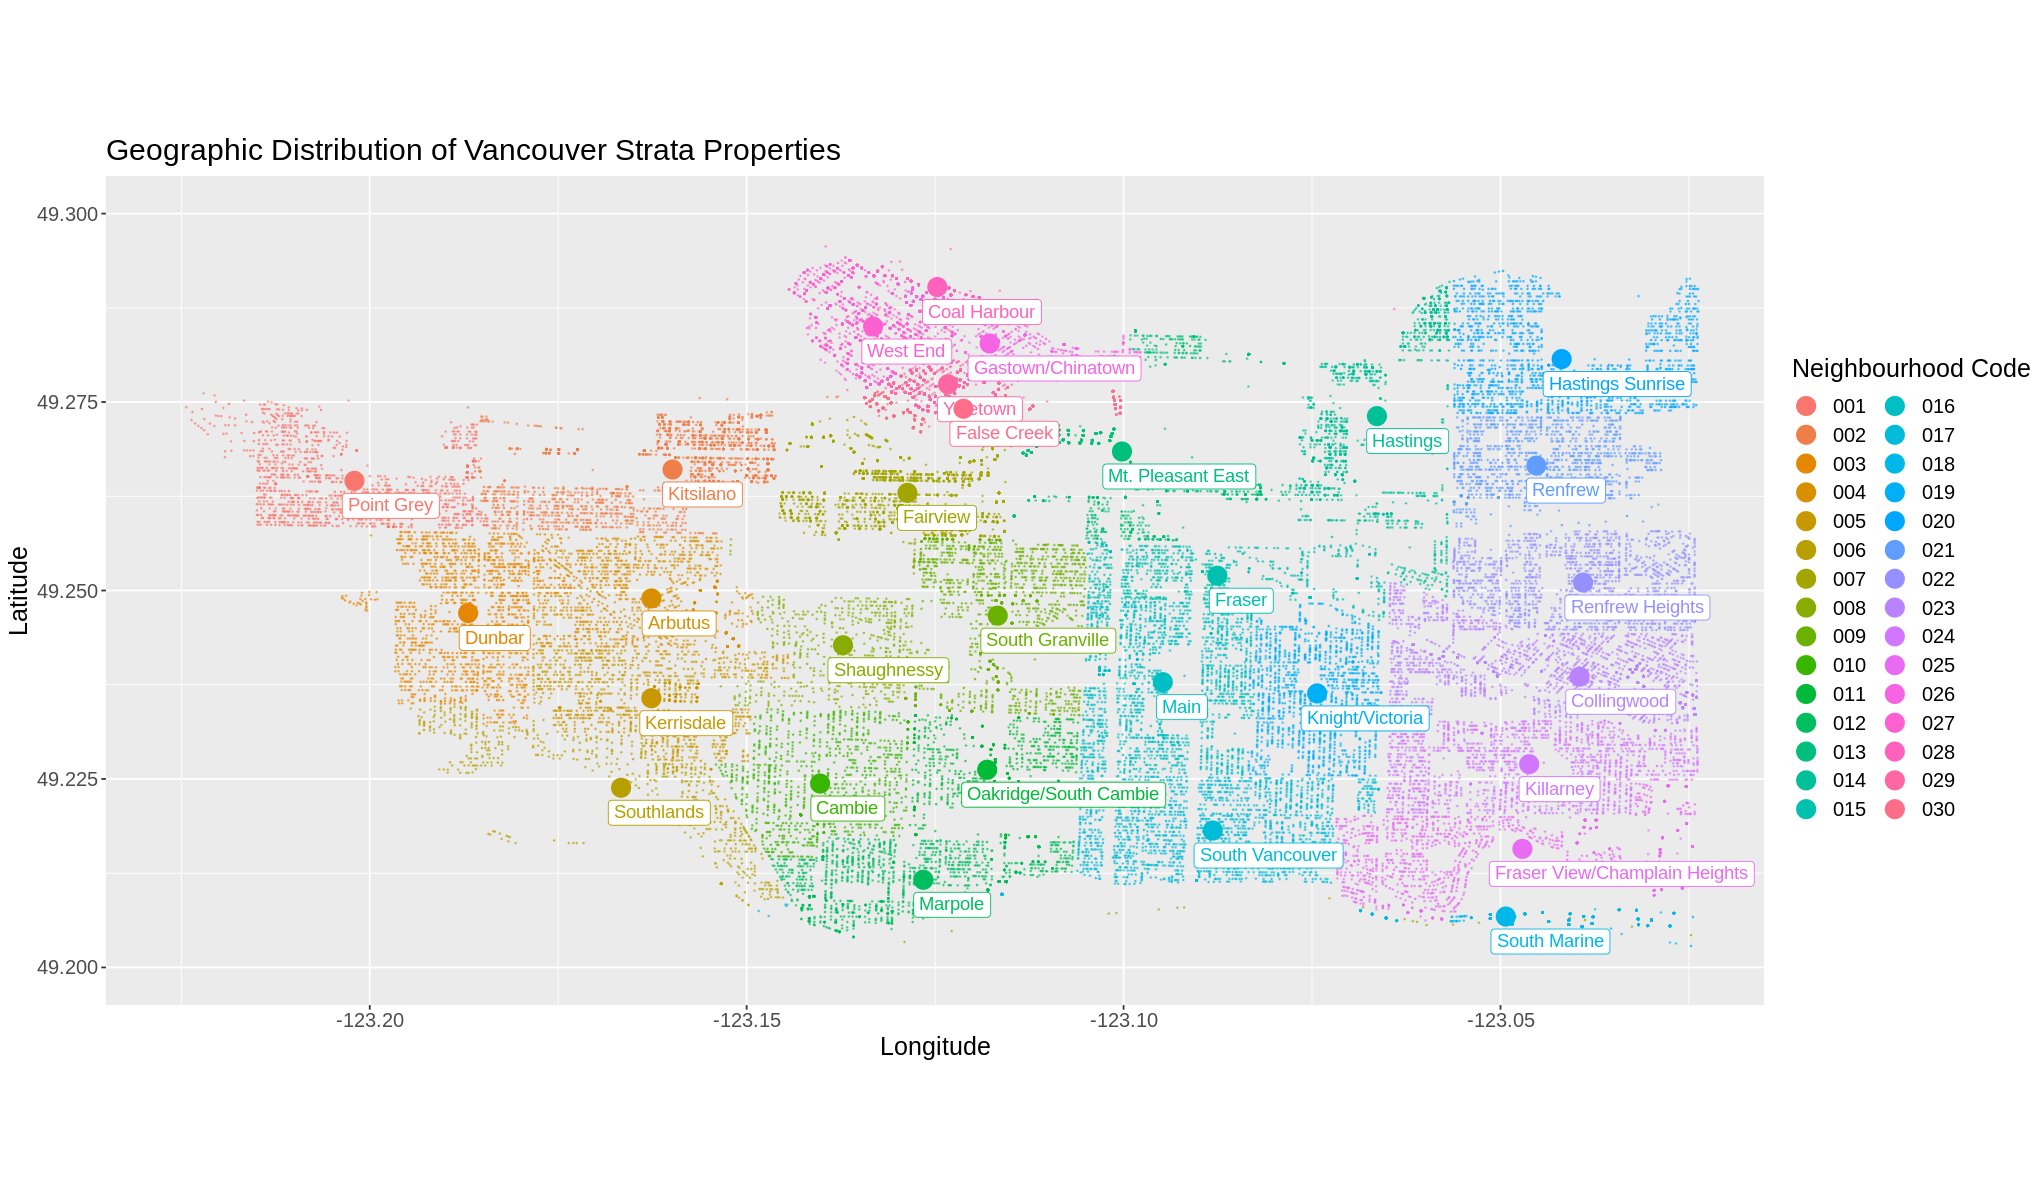

In [6]:
## Strata Only Centroid Plot
options(repr.plot.width = 17, repr.plot.height =10)
strata_only_centroid_plot <- property_housing_only |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE, color = "black")) +
                geom_point(alpha = 0.5, size = 0.125) +
                geom_label(data = ptax_centroids, aes(x=centroid_long, y=centroid_lat, label=NEIGHBOURHOOD_NAME), hjust = 0.125, vjust = 1.5) +
                geom_point(data = ptax_centroids, aes(x=centroid_long, y=centroid_lat), size = 5) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude",
                     color = "Neighbourhood Code",
                     title = "Geographic Distribution of Vancouver Strata Properties") +
                theme(text = element_text(size = 15))
strata_only_centroid_plot

<h1> 3. Feature Selection and Model Parameter Tuning </h1> 
The model will be tuned a priori using the elbow plot method, and the project will qualitively compare the results using the calculated spatial centroids from Section 3 above. From this qualitative comparison, 

First, we will narrow down the number of variables to consider. This is because many of the variables included in the data set are representative of similar things, for example "current land value" and "tax levy" could both be used as measures of how much a certain location is worth. Thus, we will first use ggpairs to form a matrix of pairs plots to see how each of the variables correlate with each other. Variables that have a moderately strong correlations will be grouped together, and the anlysis will proceed with only one variable of each group.

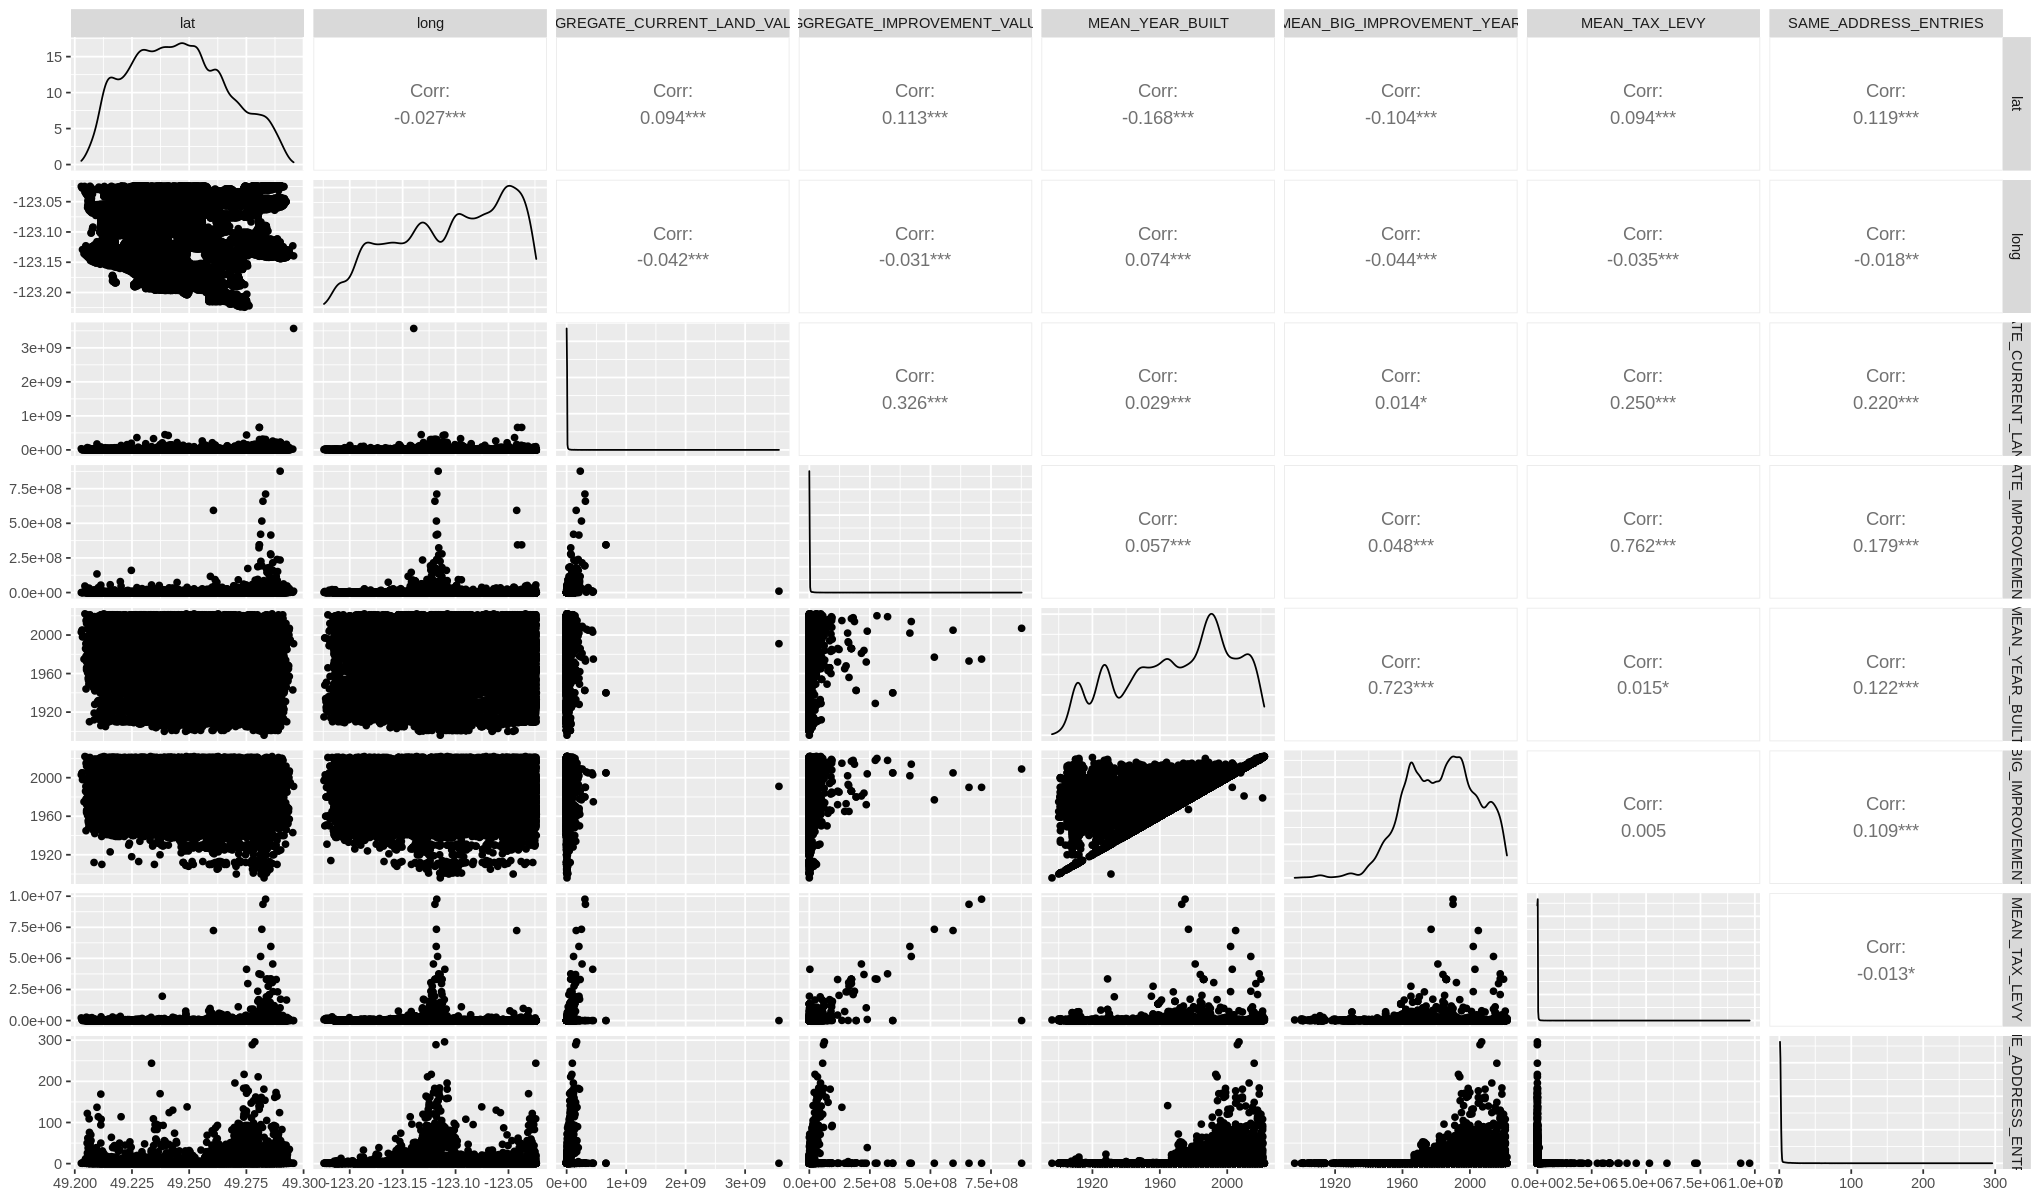

In [7]:
#using ggpairs to find how all the variable correlate with each other
ggpairs(housing_aggregated)

Based on the ggpairs plot, year built (MEAN_YEAR_BUILT) and big improvement year (MEAN_BIG_IMPROVEMENT_YEAR) have a strong correlation. In addition, many data points have the same value for year built and big improvement year, since not all buildings had major improvements. Thus, of the two we will proceed with only year built.

Likewaise, current land value (AGGREGATE_CURRENT_LAND_VALUE), current improvement value (AGGREGATE_CURRENT_IMPROVEMENT_VALUE), and tax levy (MEAN_TAX_LEVY) have moderately strong correlations, so we will proceed with only current land value. This will represent the temporal aspect of our analysis.

Latitude (lat) and longitude (long) have very weak correlations with all other variables (and with each other). Both will be kept as the spatial aspect of our analysis.

Variables kept: current land value, year built, latitude, longitude.

Next, we determine the k number of clusters to use in our model by constructing an elbow plot.

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357600)”
Warning message:
“did not converge in 10 iterations”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357600)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1357600)”


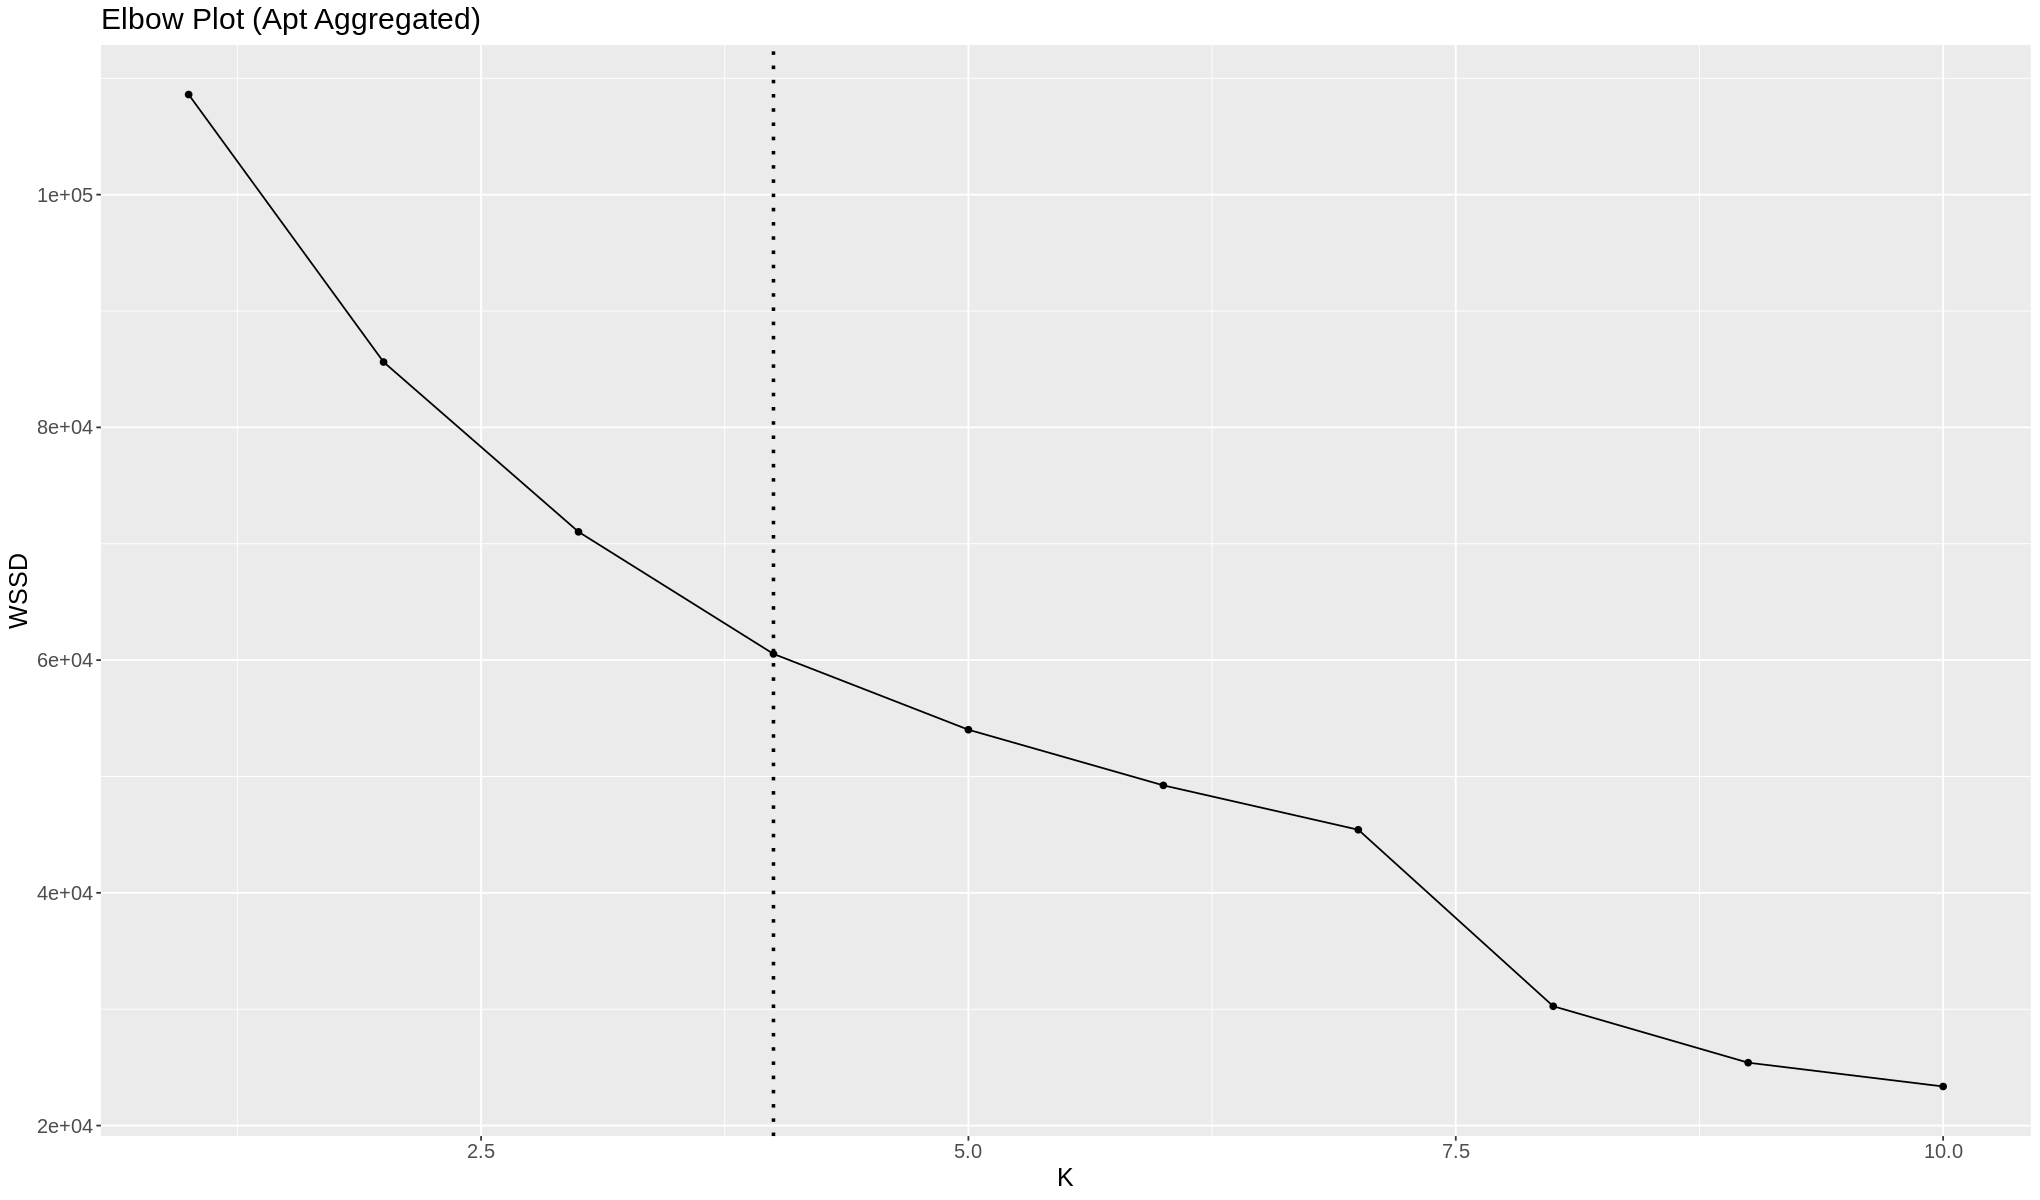

In [11]:
set.seed(9876)

#selecting for variables of interest, then scaling them all
scaled_property <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, MEAN_YEAR_BUILT, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

#gathering the information for the elbow plot to find k
elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property, nstart = 30, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

#making the elbow plot
elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K", y = "WSSD", title = "Elbow Plot (Apt Aggregated)") +
    theme(text = element_text(size = 15)) +
    geom_vline(xintercept = 4, linetype = "dotted", color = "red", size = 1)
elbow_plot

Based on the abovel elbow plot, it appears that k = 4 is the number of clusters that we will proceed with in our analysis (dotted line added for visibility, since the elbow is a little difficult to spot).

Now, we use kmeans to assign each data point to a cluster.

In [12]:
property_clusters <- kmeans(scaled_property, centers = 4) |>
    augment(scaled_property)
head(property_clusters)

AGGREGATE_CURRENT_LAND_VALUE,MEAN_YEAR_BUILT,lat,long,.cluster
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
1.1257826,1.0288472,-2.045922,1.5080932,4
0.2137768,1.0919759,-2.030545,1.4705653,4
0.2069260,1.0919759,-2.024041,1.4545969,4
-0.1734726,0.8710254,-2.020533,-0.4930898,4
-0.1045688,0.1450451,-1.988440,-0.6228550,4
-0.1734726,0.8710254,-1.976698,1.5085365,4


<h2> </h2>

<h1> 4. Clustering Model </h1>

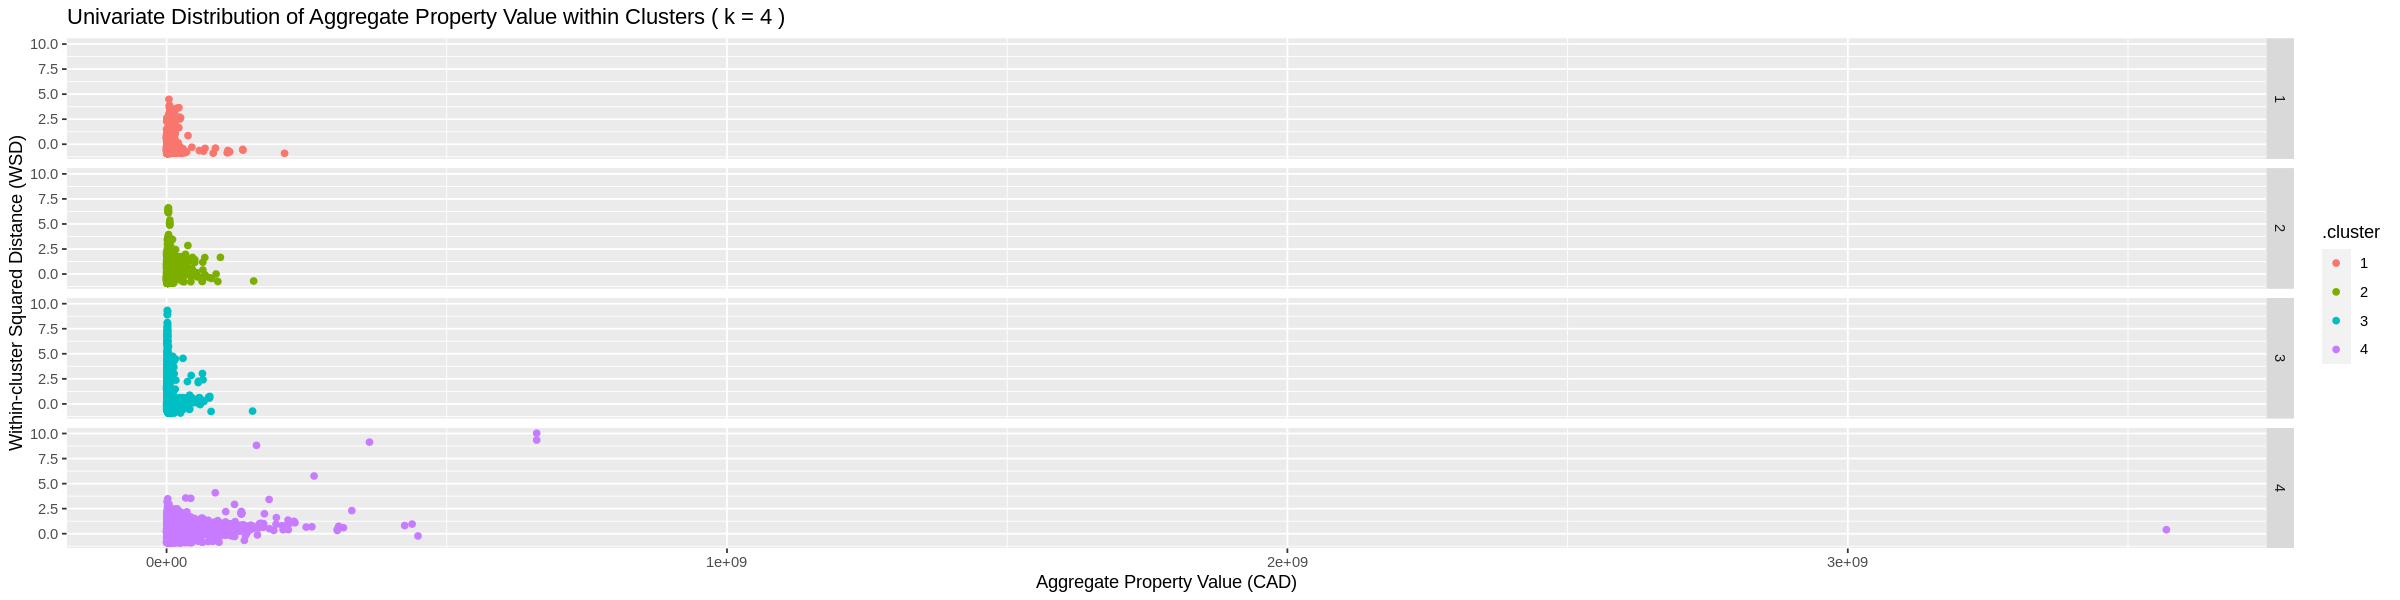

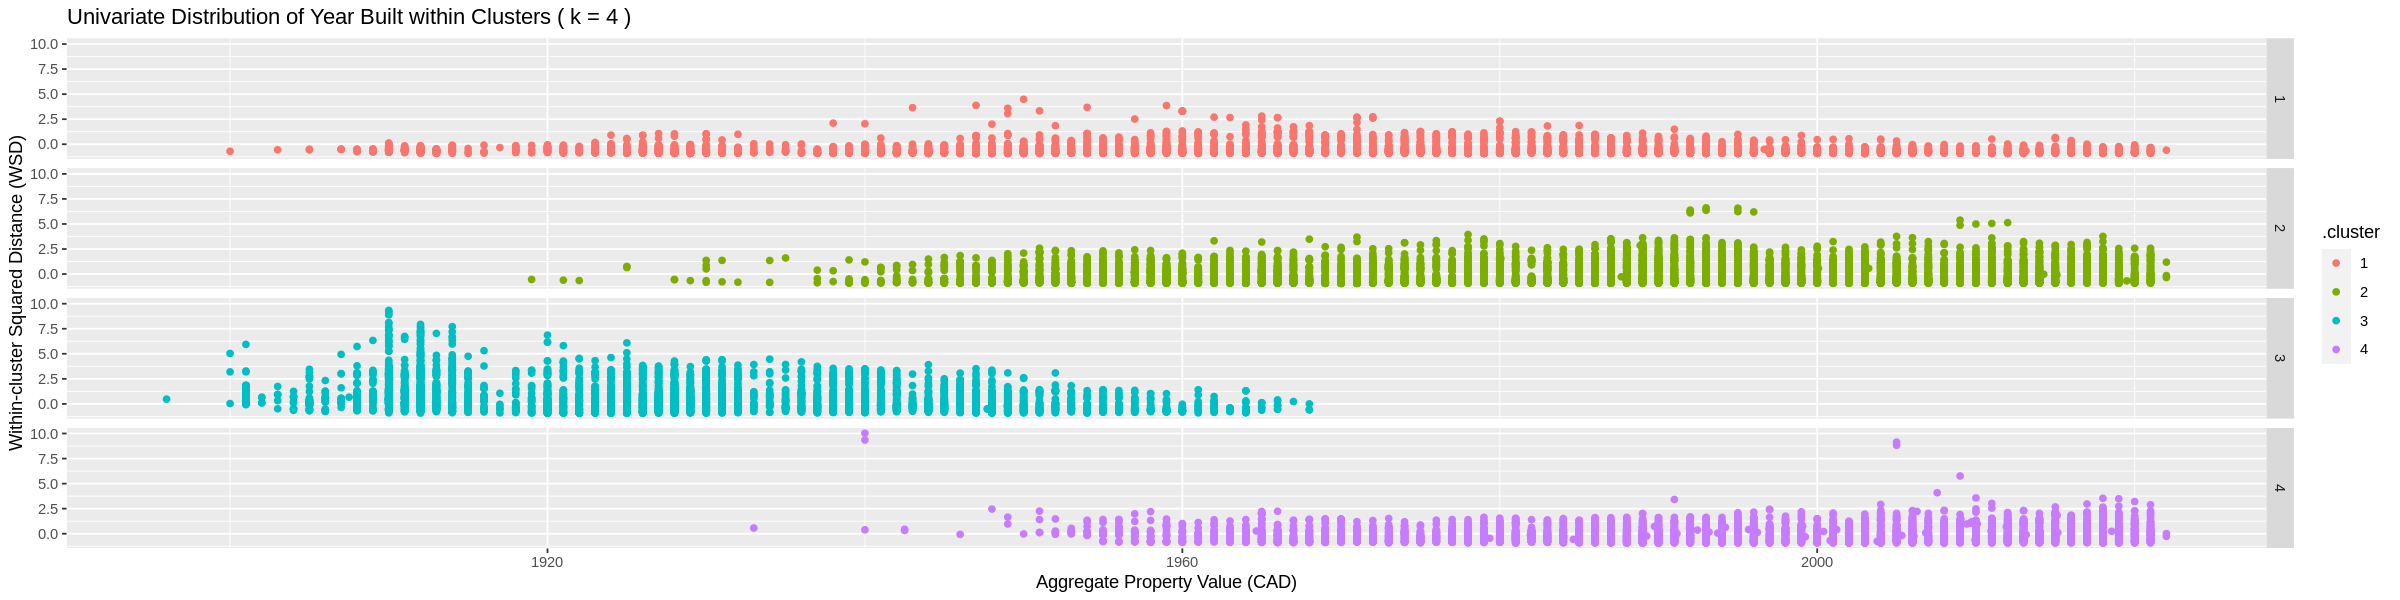

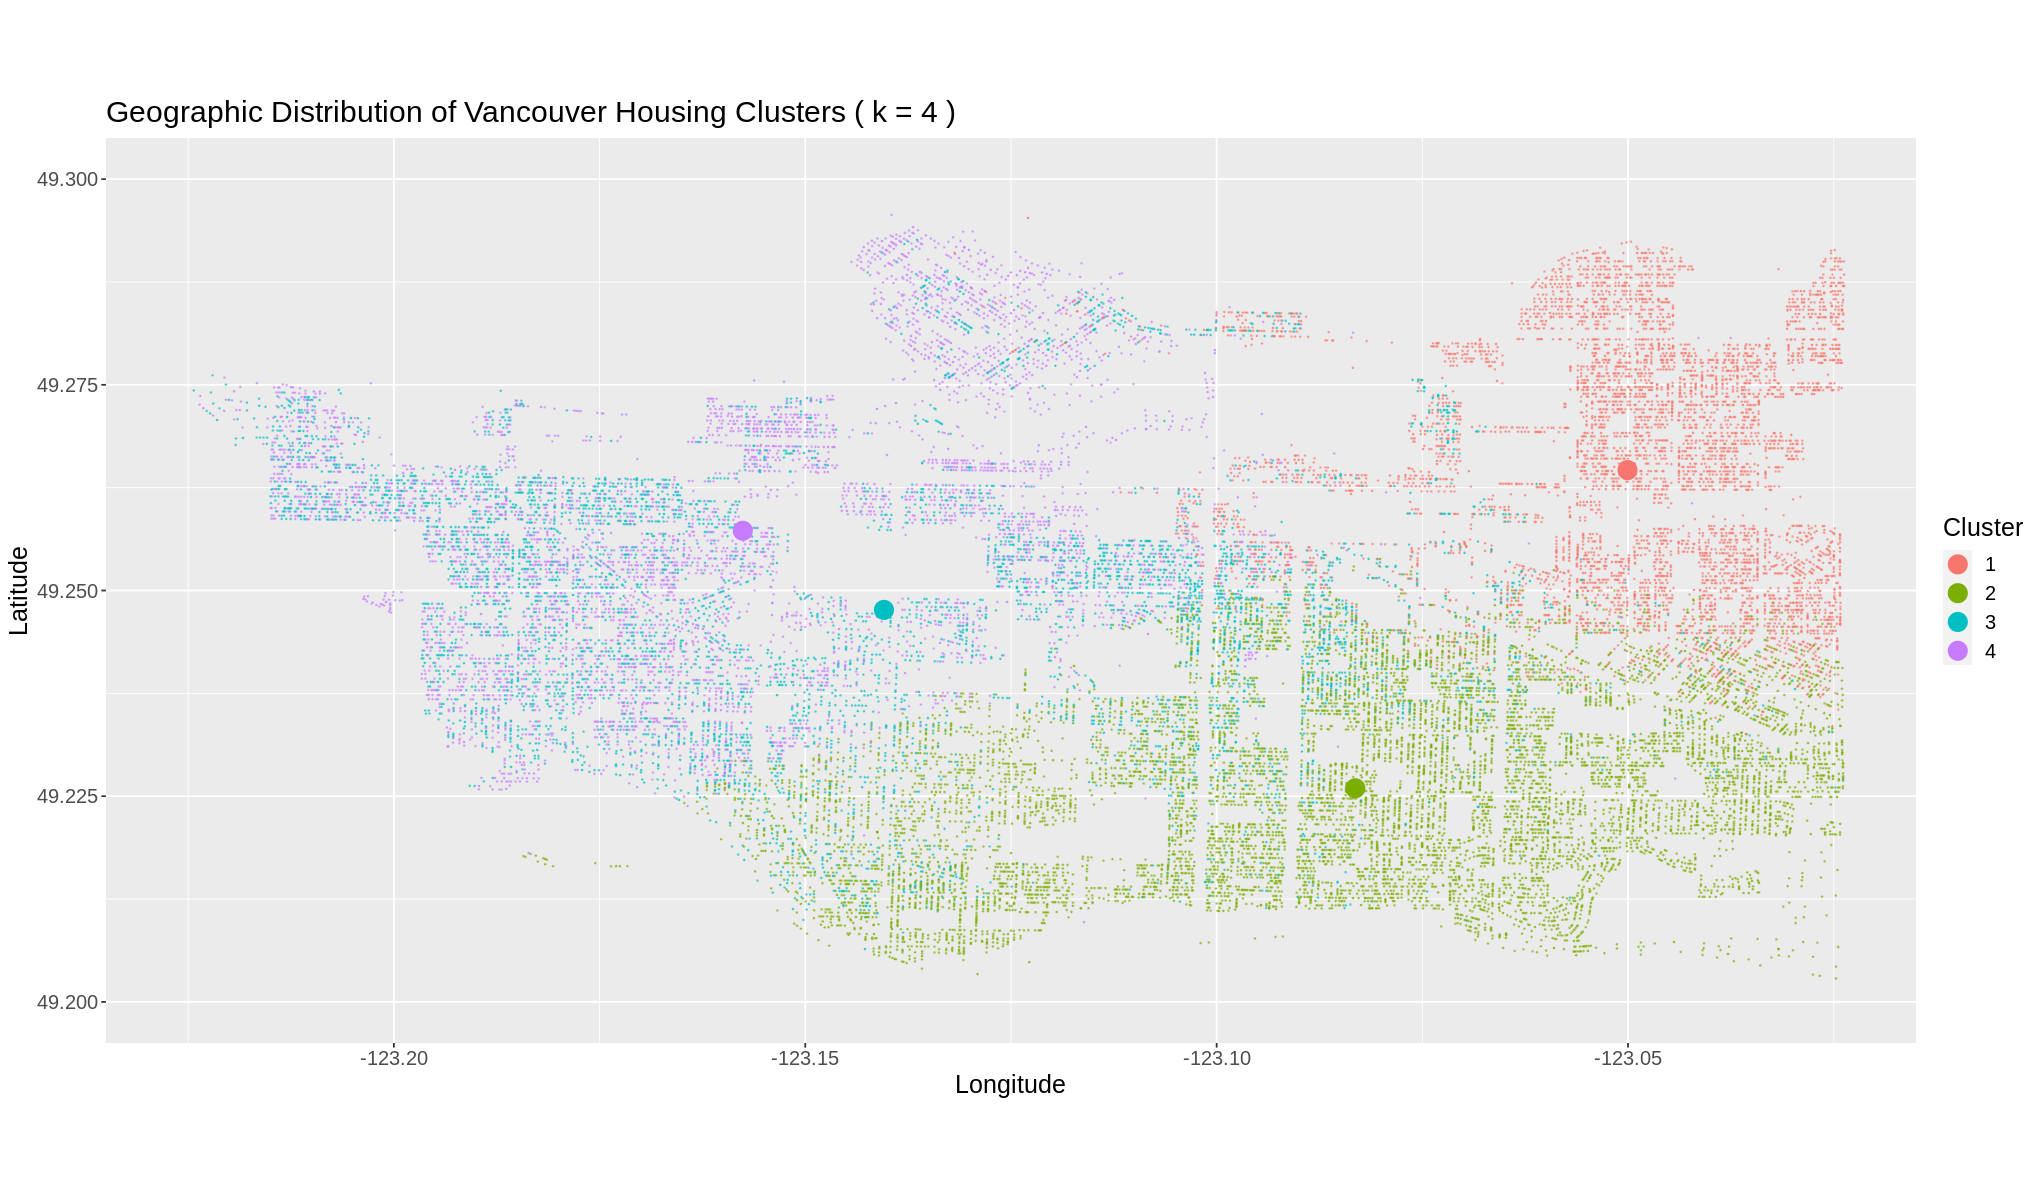

In [13]:
set.seed(seed)

## Data Specification with tuned k and selected features
# Selected k from Section 2 above
k <- 4

# Selected features from Section 2 above
housing_aggregated_selected <- housing_aggregated |>
                                select(AGGREGATE_CURRENT_LAND_VALUE,
                                       MEAN_YEAR_BUILT,
                                       lat,
                                       long)


# Calculated means and SDs of lat and long, for conversion out of scaled values
m_lat <- housing_aggregated |>
        select(lat) |>
        summarize(mean = mean(lat)) |>
        pull()
sd_lat <- m <- housing_aggregated |>
        select(lat) |>
        summarize(sd = sd(lat)) |>
        pull()
m_long <- housing_aggregated |>
        select(long) |>
        summarize(mean = mean(long)) |>
        pull()
sd_long <- m <- housing_aggregated |>
        select(long) |>
        summarize(sd = sd(long)) |>
        pull()

# Data scaling for clustering purposes
scaled_data <- housing_aggregated_selected |>
                mutate(across(everything(),scale)) 

## K-Means Model 
optimal_kmeans <- scaled_data |>
                    kmeans(centers = k, nstart = 50)

# Calculate unscaled lat and long
optimal_kmeans_centers <- optimal_kmeans$centers
optimal_kmeans_geo_centers <- as_tibble(optimal_kmeans_centers) |>
                                select(lat, long) |>
                                mutate(cluster_lat = (lat * sd_lat) + m_lat) |>
                                mutate(cluster_long = (long * sd_long) + m_long) |>
                                bind_cols(.cluster = as_factor(seq(from = 1, to = k, by = 1))) |>
                                select(cluster_lat, cluster_long, .cluster)

#Augmented Clustering Model for Distance Calculation
optimal_kmeans <- optimal_kmeans |>
                    augment(housing_aggregated)  

#Calculate within-cluster squared distance for each observation
optimal_kmeans_distances <- optimal_kmeans |>
                            left_join(optimal_kmeans_geo_centers, by = ".cluster", relationship = "many-to-many") |>
                            select(lat, long, cluster_lat, cluster_long) |>
                            mutate(WSD = (cluster_lat-lat)^2+(cluster_long-long)^2) |>
                            mutate(WSD_Scaled = scale(WSD)) |>
                            select(WSD, WSD_Scaled)
optimal_kmeans <- bind_cols(optimal_kmeans, optimal_kmeans_distances)

# Distribution of Current Property Value across clusters
options(repr.plot.width = 20, repr.plot.height =5)
property_value_cluster_dist <- optimal_kmeans |> 
                                ggplot(aes(x=AGGREGATE_CURRENT_LAND_VALUE,y=WSD_Scaled,color=.cluster)) +
                                geom_point() +
                                facet_grid(rows = vars(.cluster)) +
                                labs(x = "Aggregate Property Value (CAD)", 
                                     y = "Within-cluster Squared Distance (WSD)", 
                                     title = paste("Univariate Distribution of Aggregate Property Value within Clusters ( k =",k,")")) 
property_value_cluster_dist

# Distribution of Year property is built across clusters
options(repr.plot.width = 20, repr.plot.height =5)
property_age_cluster_dist <- optimal_kmeans |> 
                                ggplot(aes(x=MEAN_YEAR_BUILT,y=WSD_Scaled,color=.cluster)) +
                                geom_point() +
                                facet_grid(rows = vars(.cluster)) +
                                labs(x = "Aggregate Property Value (CAD)", 
                                     y = "Within-cluster Squared Distance (WSD)", 
                                     title = paste("Univariate Distribution of Year Built within Clusters ( k =",k,")")) 
property_age_cluster_dist


# Graph Geographic Distribution of Clusters
options(repr.plot.width = 17, repr.plot.height =10)
cluster_geo_dist <- optimal_kmeans |>
                ggplot(aes(x=long,y=lat,color=.cluster)) +
                geom_point(alpha = 0.5, size = 0.125) +
                geom_point(data = optimal_kmeans_geo_centers, aes(x=cluster_long, y=cluster_lat), size = 5) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude",
                     color = "Cluster",
                     title = paste("Geographic Distribution of Vancouver Housing Clusters ( k =",k,")")) +
                theme(text = element_text(size = 15))
cluster_geo_dist

In [14]:
## Prediction Examples

# A potential property in Oakridge Center, currently under construction
# https://vancouver.ca/home-property-development/oakridge-redevelopment.aspx
Pred_1 <- tibble(lat = 49.23205459271654, long = -123.11868609998048, YEAR_BUILT = 2023, NEIGHBOURHOOD_CODE = "011")

# A potential transit-oriented development in the future Arbutus station
# https://buzzer.translink.ca/2023/03/translink-announces-first-real-estate-development-project/
Pred_2 <- tibble(lat = 49.26366041287987, long = -123.15280212903731, YEAR_BUILT = 2023, NEIGHBOURHOOD_CODE = "011")

# A potential 

<h1> 5. Results Discussion </h1>

<h1> 6. Conclusion </h1>

<h1> 7. References and Resources </h1>